In [2]:
################
# Basic imports
################
import os
from datetime import datetime
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import spacy
spacy_lemma = spacy.load('en_core_web_sm')

root_dir = Path(".").parent.absolute().parent
data_dir = os.path.join(root_dir, 'data')

In [3]:
# Reading in Nation's dataset
pnation = pd.read_csv(os.path.join(data_dir, 'pnation_1000headwords.txt'),
                    names=["word"], encoding='windows-1252')

# Reading in Norvig's dataset
pnorvig = pd.read_csv(os.path.join(data_dir, 'pnorvig_count_1w.txt'),
                    names=["word","count"], delimiter="\t")

In [9]:
###########
# lemmatize Norvigs's dataset using spacy
###########
# Sidenote: in his dataset, there is an entry value "Nan" which, if read into a dataframe translate to the actual Nan value.
# To circumvent this, the values have been encapsulated as
# Sidenote2: spacy does separate compound words into their basic parts (such as doesn't => do not) and
# can also recognize typos (e.g. doesnt => doesn't). We intentionally only take the first token into account,
# however to be 100% precise you would assign the counts of a compound word to both of its original base lemmas.
# Sidenote3: iterating through every entry to lemmatize is more inefficient, than creating a string and lemmatize the string
# however with the latter approach, we don't know, which compound words have been split.

result = []
compounds =[]
spacy_words = [f"{i}" for i in pnorvig['word'].to_list()]
for idx, i in enumerate(spacy_words):
    obj = spacy_lemma(i)
    if len(obj)>1:
        compounds.append(obj)
    result.append(obj[0].lemma_)
    if idx % 10000 == 0:
        print(f"{datetime.now().strftime('%Y/%m/%d %H:%M:%S')}:Processed {idx}")
pnorvig['lemma_spacy']=result
print(len(pnorvig)) # 333333

KeyboardInterrupt: 

In [25]:
# Grouping same lemmas and summing up their count
pnorvig.sort_values(by='lemma_spacy', inplace=True)
grouped_lemma = pnorvig.groupby('lemma_spacy')['count'].sum().reset_index()
grouped_lemma.sort_values(by='count', inplace=True, ascending=False)
print(len(grouped_lemma)) # 291876

291876


In [28]:
grouped_lemma = grouped_lemma[:]
result_dict = {}
pnation_lower = pnation['word'].str.lower()
len_pnation = len(pnation_lower)

for i in range(10000, 100000, 10000):
# for equal spaces:
# steps = 50
# for i in np.linspace(0, len(grouped_lemma), steps, dtype=int):
    if i == 0:
        continue
    contained = grouped_lemma[:i][grouped_lemma[:i]['lemma_spacy'].isin(pnation_lower)]
    not_contained = grouped_lemma[:i][~grouped_lemma[:i]['lemma_spacy'].isin(pnation_lower)]
    percentage_contained = len(contained)/len_pnation
    result_dict[i] = {'contained':contained,
               'not_contained':not_contained,
               'percentage_contained': f"{percentage_contained:.2f}"}

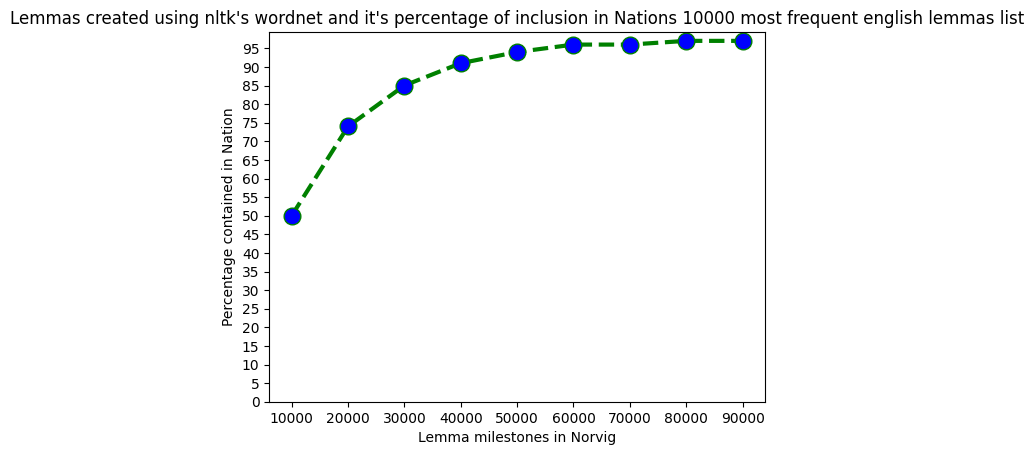

In [29]:
###########
# Plotting the result
###########

x = []
y = []
for key in result_dict:
    x.append(key)
    y.append(float(result_dict[key]['percentage_contained'])*100)
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.ylim(ymin=0)
plt.yticks(np.arange(0, 100, 5.0))
plt.xlabel('Lemma milestones in Norvig')
plt.ylabel('Percentage contained in Nation')

plt.title("Lemmas created using nltk's wordnet and it's percentage of inclusion in Nations 10000 most frequent english lemmas list")
# function to show the plot
plt.show()

In [30]:
print(f"Using the nltk wordnet library and calculating lemmas for the top 10000 \n"
      f"most frequent words provided by Norvig's dataset, covers {float(result_dict[10000]['percentage_contained'])*100}% \n"
      f"of Nation's lemma list ")

Using the nltk wordnet library and calculating lemmas for the top 10000 
most frequent words provided by Norvig's dataset, covers 50.0% 
of Nation's lemma list 


In [31]:
##########
# Export
##########
pnorvig.sort_values(by='count', inplace=True, ascending=False)
pnorvig.to_csv(os.path.join(root_dir,'spacy_lemma','pnorvig_count_1w_lemma_spacy.txt'), index=None)
pd.DataFrame([i.text for i in compounds]).to_csv(os.path.join(root_dir,'spacy_lemma','pnorvig_count_1w_lemmacompounds_spacy.txt'), index=None, header=False)

'interesting'